## NTSB Narrative Data Exploration

Exploration of the Narrative Data provided by the National Transportation Safety Board, primarily focusing on the "probable cause" column.

Notebook includes:
- Text json Data Ingestion
- Text pre-processing
- Corpus counts
- Corpus counts over time
- Topic modeling (LDA)

In [1]:
#Import packages
import pandas as pd 
import os 
from gensim.models import ldamodel 
import gensim.corpora
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

%matplotlib inline

## Data Ingestion

In [2]:
df = pd.DataFrame()

#Read in narrative json files from data directory, parse json file to columns, append to one dataframe
for file in os.listdir("data"):
    if file.startswith("NarrativeData_"):
        df = df.append(pd.read_json(os.path.join('data/', file), orient='split'))
        
print('The NTSB narrative json data contains {} columns and {} rows.'.format(df.shape[1], df.shape[0]))

The NTSB narrative json data contains 3 columns and 76133 rows.


In [3]:
df.head()

,EventId,narrative,probable_cause
0,20100412X54138,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...
1,20001212X22328,NTSB investigators may have traveled in suppor...,A total loss of engine power for undetermined ...
2,20001211X11810,NTSB investigators may not have traveled in su...,THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...
3,20001207X04295,NTSB investigators may not have traveled in su...,the accidental discharge of a spear gun by the...
4,20030827X01411,NTSB investigators may not have traveled in su...,The failure of the exhaust valve on the number...


## Text Pre-Processing

- Stopwords
- Case conversion
- Porter Stemming
- Punctuation Removal
- Digit Removal

In [4]:
#Get list of english stopwords from the nltk package
from nltk.corpus import stopwords
stop = stopwords.words('english')

#Remove punctuation from stopwords list
stop = [re.sub('[^\w\s]','', word) for word in stop]

#Add custom stopwords based on context
stop = stop + ['ntsb', 'result', 'factor', 'may', 'contribut', 'due', 'reason', 'related']

In [5]:
#Function to clean text
def clean_text(x, stopwords):
    
    """
    Performs text pre-processing on string: case converstion, punctuation & digit removal, tokenization, porter stemming, and stopword removal.
    
    Parameters:
    
    x - String to be processed
    stopwords - A list of strings to be used as stop words
    
    """
    
    x = re.sub(r'[^\w\s]','',x) #Remove punctuation
    x = re.sub(r'[^\D\s]','',x) #Remove digits
    x = x.lower().split() #Tokenize and lowercase text
    
    #Porter Stemming & stop word removal
    ps = PorterStemmer()
    x = [ps.stem(word) for word in x if word not in stopwords]

    #Return processed text
    return(x)

#Create processed versions of 'narrative' and 'probable_cause' columns using clean_text() function
df['probable_cause_clean'] = df.apply(lambda x: clean_text(x.probable_cause, stopwords=stop), axis=1)
df['narrative_clean'] = df.apply(lambda x: clean_text(x.narrative, stopwords=stop), axis=1)

In [6]:
df.head()

,EventId,narrative,probable_cause,probable_cause_clean,narrative_clean
0,20100412X54138,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...,"[pilot, failur, maintain, direct, control, air...","[investig, use, data, provid, variou, entiti, ..."
1,20001212X22328,NTSB investigators may have traveled in suppor...,A total loss of engine power for undetermined ...,"[total, loss, engin, power, undetermin, reason]","[investig, travel, support, investig, use, dat..."
2,20001211X11810,NTSB investigators may not have traveled in su...,THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...,"[student, pilot, failur, maintain, aircraft, d...","[investig, travel, support, investig, use, dat..."
3,20001207X04295,NTSB investigators may not have traveled in su...,the accidental discharge of a spear gun by the...,"[accident, discharg, spear, gun, observ]","[investig, travel, support, investig, use, dat..."
4,20030827X01411,NTSB investigators may not have traveled in su...,The failure of the exhaust valve on the number...,"[failur, exhaust, valv, number, two, engin, cy...","[investig, travel, support, investig, use, dat..."


## Corpus Frequency

What are the most common words in corpus?

Produce two plots: Top 20 tokens in probable_cause and narrative columns after pre-processing

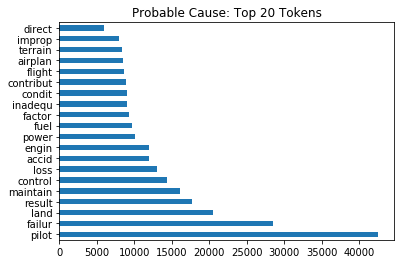

In [9]:
pd.Series([x for item in df.probable_cause_clean for x in item]).value_counts()[:20].plot(kind='barh')
plt.title('Probable Cause: Top 20 Tokens')
plt.show()

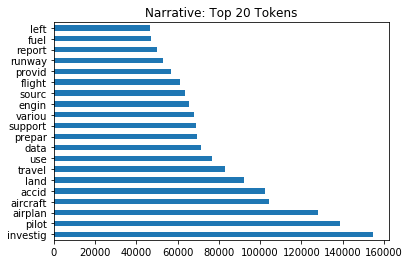

In [10]:
pd.Series([x for item in df.narrative_clean for x in item]).value_counts()[:20].plot(kind='barh')
plt.title('Narrative: Top 20 Tokens')
plt.show()

## Corpus Frequency over Time

How do the common words in the corpus change over time?

In [57]:
# Merge to cleaned aviation data from NTSB.ipynb to get date data
ntsb  = pd.read_csv('data/aviation_data.csv')

#Make sure eventID's are captalized the same so they merge correctly
ntsb['EventId'] = ntsb['EventId'].str.upper()
df['EventId'] = df['EventId'].str.upper()

merged = df.merge(ntsb, on='EventId')

#Create dataframe that has one row per word in the probable cause data, with associated year
counts_df = merged[['EventId', 'probable_cause_clean', 'year']].explode('probable_cause_clean')

#Limit data to 1993-2014
#"Full narrative descriptions may not be available for dates before 1993"
#2015 does not have a full year of data so counts may be misleading
mask = (counts_df['year'] >= 1993) & (counts_df['year'] < 2015)
counts_df = counts_df.loc[mask]

#Create aggregate counts of words by year
word_counts = counts_df.groupby(['year', 'probable_cause_clean']).agg({'count'}).reset_index()
word_counts.columns = ['year', 'token', 'count']
word_counts.head()

,year,token,count
0,1993,aar,1
1,1993,abil,9
2,1993,abl,2
3,1993,abort,49
4,1993,abrupt,7


In [58]:
#Get all words that were ever in the top five by counts each year
top5words = word_counts.sort_values('count',ascending=False).groupby('year').head(5).token.unique().tolist()
top5words

['pilot',
 'failur',
 'land',
 'result',
 'maintain',
 'contribut',
 'accid',
 'loss',
 'control']

In [59]:
#Subset data to top 5 words, pivot for ploting
word_counts_limited = word_counts[word_counts['token'].isin(top5words)]
plot_df = word_counts_limited.pivot(index = 'year', columns = 'token', values = 'count').reset_index()
plot_df.head()

token,year,accid,contribut,control,failur,land,loss,maintain,pilot,result
0,1993,657,199,509,1270,633,439,657,1797,501
1,1994,585,103,474,1258,663,441,653,1680,521
2,1995,578,140,474,1364,804,492,653,1926,609
3,1996,585,98,499,1370,946,474,633,1964,710
4,1997,466,162,467,1272,858,471,634,1838,633


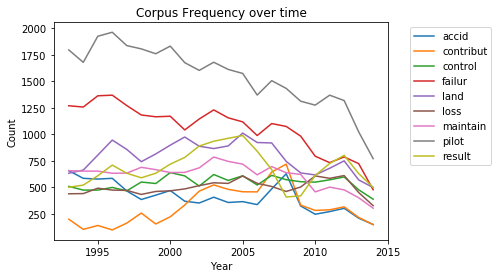

In [61]:
#Plot counts over time
for column in plot_df.columns[1:len(plot_df.columns)] :
    plt.plot(plot_df['year'], plot_df[column], label = column)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Corpus Frequency over time')
plt.legend(bbox_to_anchor=(1.05, 1))

## Topic Modeling

Topic Modeling with LDA (Latent Dirchlet Allocation) to find themes in probable cause text.

In [70]:
#Get array of probable cause text for input into the lda model
training = [value[0] for value in df[['probable_cause_clean']].values]

#Define number of topics for LDA to produce
num_topics = 8

#Get mapping between words and their ids
id2word = gensim.corpora.Dictionary(training)

#Create Corpus
corpus = [id2word.doc2bow(text) for text in training]

#Run LDA model
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [71]:
#Print words in topics
for index, topic in lda.show_topics(formatted=False, num_words= 15):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['engin', 'loss', 'power', 'undetermin', 'reason', 'failur', 'land', 'forc', 'mainten', 'result', 'terrain', 'carburetor', 'partial', 'contribut', 'lack']
Topic: 1 
Words: ['pilot', 'condit', 'flight', 'failur', 'factor', 'weather', 'approach', 'accid', 'proper', 'instrument', 'night', 'contribut', 'dark', 'continu', 'decis']
Topic: 2 
Words: ['control', 'pilot', 'failur', 'maintain', 'direct', 'land', 'airplan', 'loss', 'flight', 'result', 'student', 'aircraft', 'instructor', 'roll', 'inadequ']
Topic: 3 
Words: ['fuel', 'pilot', 'inadequ', 'result', 'engin', 'power', 'loss', 'preflight', 'exhaust', 'improp', 'plan', 'failur', 'starvat', 'land', 'accid']
Topic: 4 
Words: ['pilot', 'failur', 'maintain', 'result', 'airspe', 'altitud', 'stall', 'collis', 'adequ', 'maneuv', 'inadvert', 'terrain', 'clearanc', 'low', 'climb']
Topic: 5 
Words: ['land', 'pilot', 'result', 'gear', 'improp', 'flare', 'failur', 'hard', 'main', 'nose', 'recoveri', 'bounc', 'rotor', 'right', 'left'